# FFT Convolution and other things

There are two points I want to address in this notebook:

1. FFT convolution and zero padding
2. reflection and conjugation
---
1. http://dsp.stackexchange.com/questions/736/how-do-i-implement-cross-correlation-to-prove-two-audio-files-are-similar
2. http://www.dspguide.com/ch18/2.htm

In [11]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## FFT convolution and zero padding

FFT convolution is a little more complicated than the mathematical formula would suggest. Mathematically we have $f \otimes g = \mathcal{F}^{-1}(F \times G)$ where $\mathcal{F}$ represents the fourier transform operation and $f$ and $F$ and $g$ and $G$ are fourier transform pairs.

However, when we perform the calculation numerically we have to remember that our signal is _not_ infinite and that in fact we are performing a _circular convolution_[1, 2]. That means that we have to pad our signal and kernel with enough zeros that this doesn't happen. I haven't been doing this with most of my FFT convolutions. But because I'ave been using small kernels (PSFs are small) and shifting them to begin with I haven't noticed the effect.

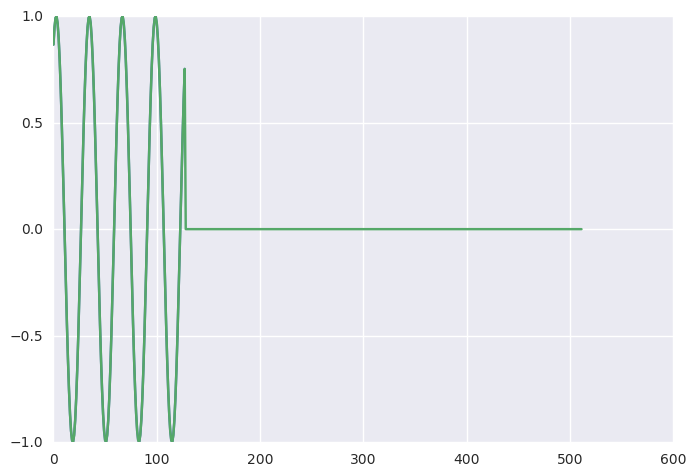

In [16]:
x = arange(128)
y = sin(2 * pi * x / 128 * 4 + pi / 3)
newshape = 512
ytest = irfft(rfft(y))
assert allclose(ytest, y)

y2 = irfft(rfft(y, newshape), newshape)
plot(y)
plot(y2)

In [17]:
from scipy.signal import fftconvolve

AssertionError: 

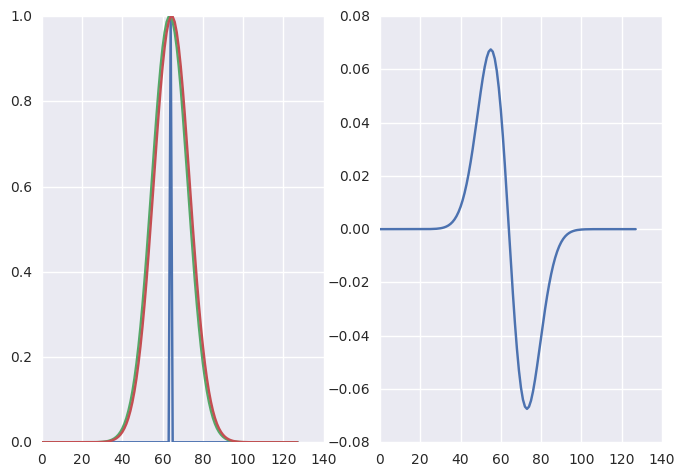

In [81]:
x = linspace(-5, 5, 128, True)
y = exp(-x**2)

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(128) == 64
ax0.plot(imp)

conv = fftconvolve(y, imp, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y-conv)
assert allclose(y, conv)

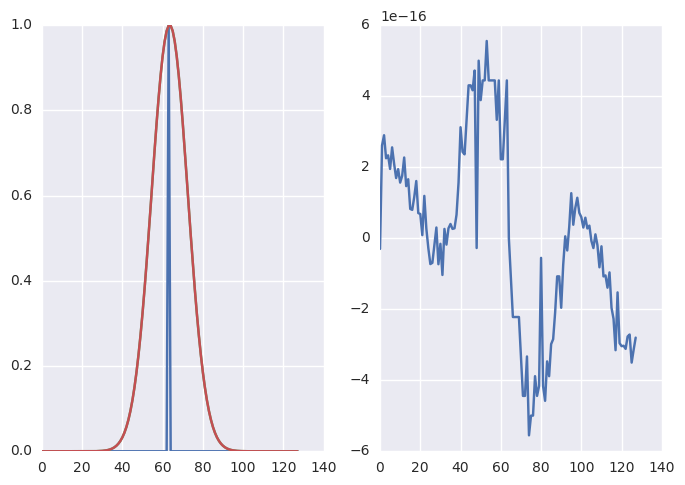

In [82]:
x = linspace(-5, 5, 128, True)
y = exp(-x**2)

fig, (ax0, ax1) = subplots(1, 2)

imp = arange(128) == 63
ax0.plot(imp)

conv = fftconvolve(y, imp, "same")
ax0.plot(y)
ax0.plot(conv)
ax1.plot(y-conv)
assert allclose(y, conv)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]

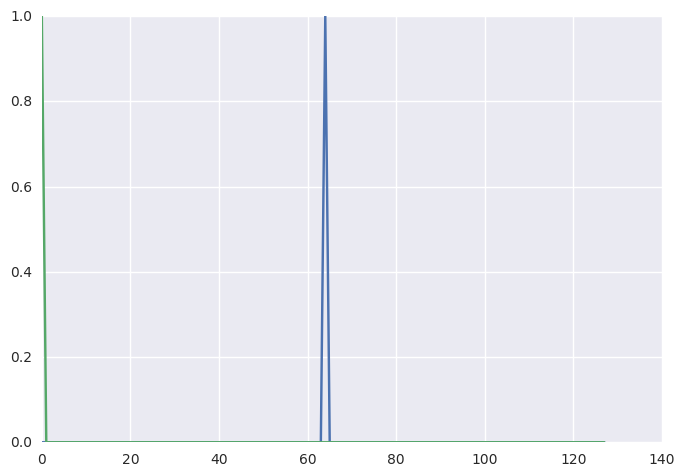

In [76]:
plot(imp)
plot(fftshift(imp))
fftshift(imp)

In [ ]:
def richardson_lucy(image, psf, iterations=10, prediction_order=2):
    """Richardson-Lucy deconvolution."""
    image, psf = _prep_img_and_psf(image, psf)
    otf = rfftn(psf)
    # initialize variable for iterations
    # previous estimate
    u_tm1 = None
    # current estimate
    u_t = image
    # previous difference
    g_tm1 = None
    for i in range(iterations):
        # call the update function
        u_tp1 = rl_core(image, otf, u_t)
        # enure positivity
        u_tp1[u_tp1 < 0] = 0
        # update estimate
        u_t = u_tp1
    # return final estimate
    return u_tp1


def rl_core(image, otf, y_t):
    """The core update step of the RL algorithm"""
    reblur = irfftn(otf * rfftn(y_t), y_t.shape)
    im_ratio = image / reblur
    estimate = irfftn(np.conj(otf) * rfftn(im_ratio), im_ratio.shape)
    return y_t * estimate

## Reflection and conjugation

One other issue that I've come across is that Fourier transforming a signal, taking the conjugate and then inverse Fourier Transformation doesn't reverse the signal, exactly, as it should. It's one sample off.

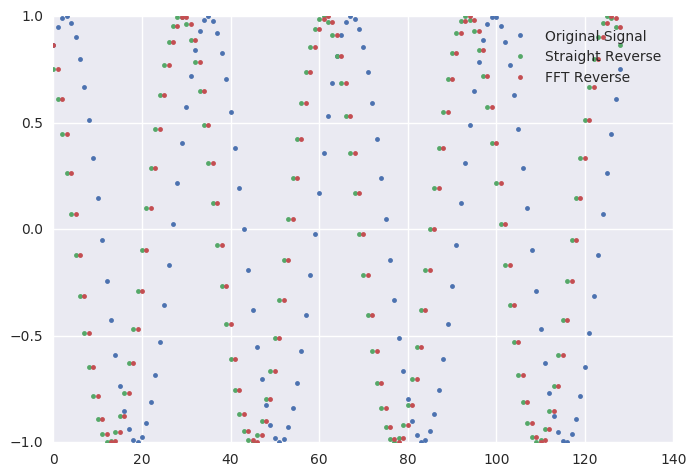

In [99]:
x = arange(129)
y = sin(2 * pi * x / 129 * 4 + pi / 3)
y_rev = y[::-1]
y_rev_fft = irfft(conj(rfft(y, 129)), 129)

plot(y, ".", label="Original Signal")
plot(y_rev, ".", label="Straight Reverse")
plot(y_rev_fft, ".", label="FFT Reverse")
# plot(roll(y_rev_fft, -1), label="FFT Reverse Shift -1")
legend()
savefig("FFT Conjugation Reversal.png")

As you can see the conjugated version _does_ reverse the signal but it is off by one sample. Why is this?

I posed this question on [stackexchange](http://dsp.stackexchange.com/questions/35088/fourier-transform-gives-unexpected-results-signal-reversal-and-conjugation).

The basic answer is that reversing the signal point by point is equivalent to chosing a mirror plane between samples whereas reversing it with the FFT uses an actual sample.

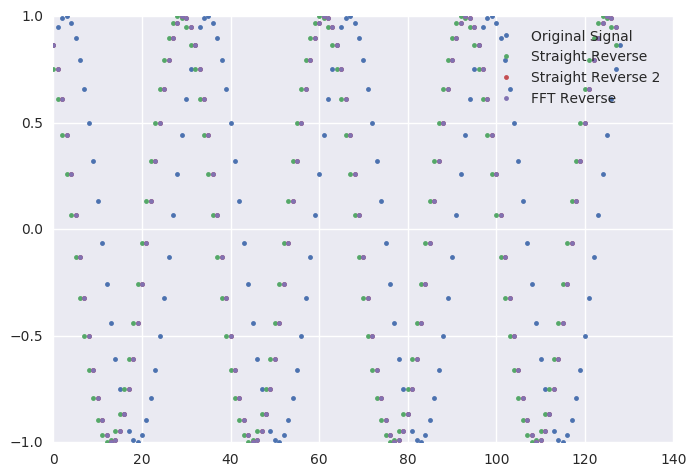

In [111]:
x = arange(128)
y = sin(2 * pi * x / 128 * 4 + pi / 3)
# explicitly reverse about origin
y_rev = y[::-1]
y_rev_fft = irfft(conj(rfft(y)))

x = arange(129)
y = sin(2 * pi * x / 128 * 4 + pi / 3)
y_rev2 = y[:0:-1]

plot(y, ".", label="Original Signal")
plot(y_rev, ".", label="Straight Reverse")
plot(y_rev2, ".", label="Straight Reverse 2")
plot(y_rev_fft, ".", label="FFT Reverse")
# plot(roll(y_rev_fft, -1), label="FFT Reverse Shift -1")
legend()

In [112]:
assert allclose(y_rev2, y_rev_fft)